### **Blank Image vs Battery Classifier**  *Version 2*

### Imports

In [1]:
import tensorflow as tf
import os

# Avoid OOM Errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

2024-04-01 14:26:12.794719: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 14:26:12.966479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 14:26:12.966526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 14:26:12.990256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 14:26:13.048056: I tensorflow/core/platform/cpu_feature_guar

[]

In [2]:
import cv2 # For import issues: https://github.com/ultralytics/ultralytics/issues/1270
import imghdr

data_dir = 'blank-battery-data' # Currently data is google images for 'cylinder batteries' and 'coin cell batteries'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

## Test
# import matplotlib.pyplot as plt
# test_img = cv2.imread(os.path.join('data','coin','button-cell.jpg'))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # openCV uses BGR for some reason
# plt.show()


In [3]:
## Cleaning Datasets
import os
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) # Checks if image can be read
            tip = imghdr.what(image_path) # Grabs extension of each file
            if tip not in image_exts:
                os.remove(image_path)
        except Exception as e:
            os.remove(image_path)

In [4]:
## Loading Data
import numpy as np
import matplotlib.pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('blank-battery-data') # Creates tf dataset (loads, resizes, batches data)
data_iterator = data.as_numpy_iterator() # Creates iterator for data object
batch = data_iterator.next() # Images and Labels. Shape = (32, 256, 256, 3)
    # might need to drop batch size for GPU cost

Found 300 files belonging to 2 classes.


### Preprocess

In [5]:
## Scale Data [0,255] --> [0,1]
data = data.map(lambda x,y:(x/255, y)) 
    # data.map allows for in-line pipeline 
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

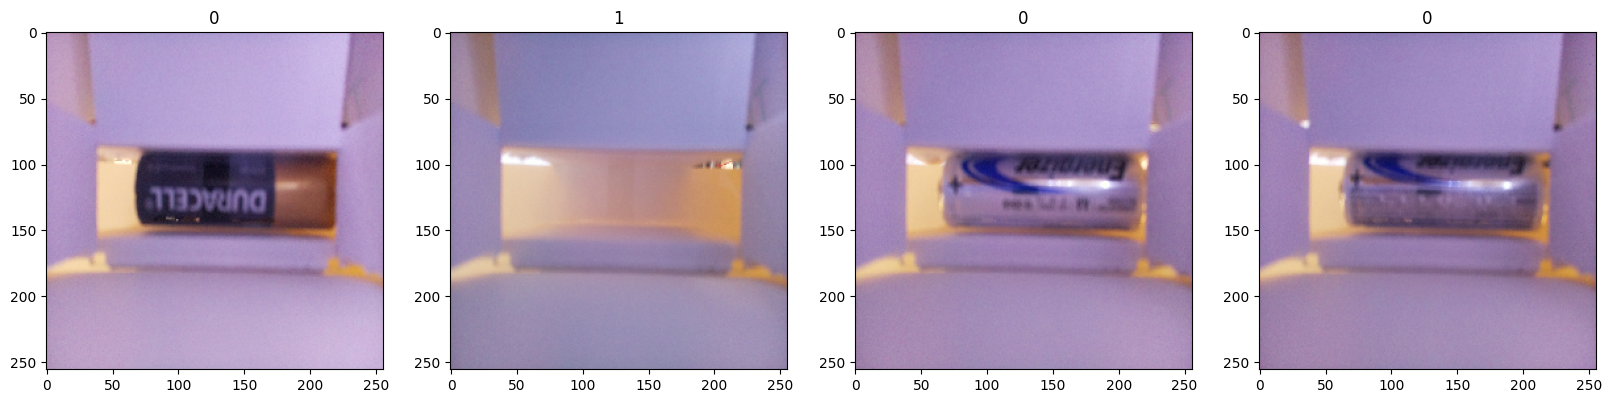

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

<h5><center>In the images above, 0: Blank and 1:Battery</center></h5>

In [7]:
## Split Data
num_batches = len(data)
train_size = int(num_batches*0.6) 
val_size = int(num_batches*0.3)
test_size = int(num_batches*0.1) 

while train_size + val_size + test_size < num_batches:
    test_size += 1

print(f"Train Size: {train_size}, Validation Size: {val_size}, Test Size: {test_size}")
print(f"Number of Batches: {num_batches}")

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


Train Size: 6, Validation Size: 3, Test Size: 1
Number of Batches: 10


### **Deep Model**

#### Building DNN

In [8]:
from tensorflow.keras.models import Sequential, Model # takes only one input as feed and expects one output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

## Adding layers sequentially
# Convulution Layers - using mainly relu activations 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) # Input Layer
model.add(MaxPooling2D()) # Returns max value over (2,2) region, reducing image size by 1/2

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # reduces the input data into a single dimension instead of 2 dimensions.

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # One value as output (0 or 1)


In [9]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.summary()

### Train

In [10]:
path_checkpoint = "training_1/cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)
callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                                 save_weights_only=True,
                                                 verbose=1)
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[callback])
# hist.history 

Epoch 1/10


6/6 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.6354
Epoch 1: saving model to training_1/cp.ckpt
6/6 [==============================] - 11s 1s/step - loss: 0.7697 - accuracy: 0.6354 - val_loss: 0.6084 - val_accuracy: 0.8333
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.5760 - accuracy: 0.7135
Epoch 2: saving model to training_1/cp.ckpt
6/6 [==============================] - 11s 1s/step - loss: 0.5760 - accuracy: 0.7135 - val_loss: 0.4633 - val_accuracy: 0.9792
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.9219
Epoch 3: saving model to training_1/cp.ckpt
6/6 [==============================] - 11s 1s/step - loss: 0.3562 - accuracy: 0.9219 - val_loss: 0.2003 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 1.0000
Epoch 4: saving model to training_1/cp.ckpt
6/6 [==============================] - 10s 1s/step - loss: 0.1177 - accuracy: 1.0000 -

In [11]:
model.save('blank-battery-model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

_________________________________________________________________


/home/mani/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Plot Performance

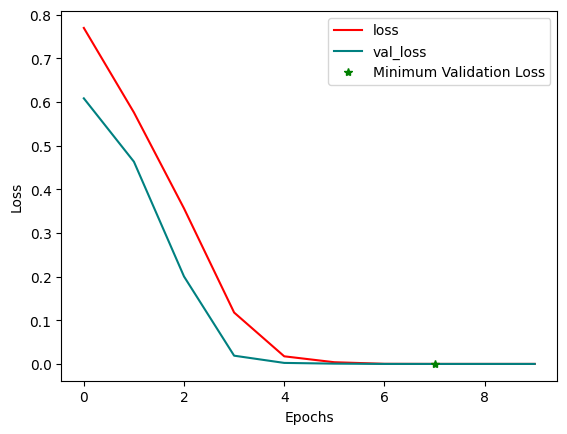

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label='loss')
plt.plot(hist.history['val_loss'], color = 'teal', label='val_loss')
plt.plot(np.argmin((hist.history['val_loss'])), min(hist.history['val_loss']), color = 'green', label = 'Minimum Validation Loss', marker='*', linestyle = '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()

*Model is overfitting - this will be key in actual sorting*

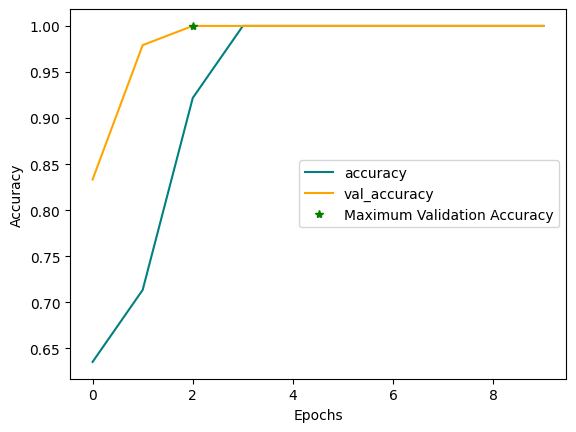

In [13]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(np.argmax((hist.history['val_accuracy'])), max(hist.history['val_accuracy']), color = 'green', label = 'Maximum Validation Accuracy', marker='*', linestyle = '')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="right")
plt.show()

### Evaluate and Test

In [14]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): # testing data
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

print(f"Precision: {pre.result()}")
print(f"Recall: {re.result()}") 
print(f"Accuracy: {acc.result()}")

1/1 [==============================] - 0s 302ms/step
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


### Self Testing w/ own images

1/1 [==============================] - 0s 22ms/step
[[0.00374527]]
1/1 [==============================] - 0s 23ms/step
[[0.9945194]]


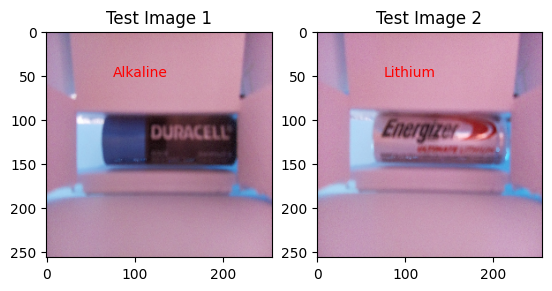

In [37]:
img1 = cv2.imread(os.path.join('user-data', 'image18-0.jpeg'))
img2 = cv2.imread(os.path.join('user-data', 'image2-3.jpeg'))
# im3 = cv2.imread(os.path.join('user-data', 'image18-0.jpeg'))
resize1 = tf.image.resize(img1, (256,256))
resize2 = tf.image.resize(img2, (256,256))
# resize3 = tf.image.resize(img2, (256,256))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(resize1.numpy().astype(int))
axarr[0].set_title('Test Image 1')
axarr[1].imshow(resize2.numpy().astype(int))
axarr[1].set_title('Test Image 2')
# axarr[2].imshow(resize3.numpy().astype(int))
# axarr[2].set_title('Test Image 3')

yhat1 = model.predict(np.expand_dims(resize1/255,0))
print(yhat1)
label1 = 'Alkaline' if yhat1 < 0.5 else 'Lithium'
yhat2 = model.predict(np.expand_dims(resize2/255,0))
print(yhat2)
label2 ='Alkaline' if yhat2 < 0.5 else 'Lithium'

# yhat3 = model.predict(np.expand_dims(resize3/255,0))
# print(yhat3)

# label1 

axarr[0].text(75, 50, label1, color='red')
axarr[1].text(75, 50, label2, color='red')
# axarr[2].text(75, 50, label3, color='red')

plt.show()